### Stacking Attempt  
  
Model stacking is the process of taking a few different base models which are trained on the training set and then make predictions on the validation set. The predictions of these base models on the validation set then are combined as a new feature set. The meta model is trained on this new feature set and makes predicts on the testing set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

In [4]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [5]:
activity_indexes = pd.read_csv('activity_indexes.csv')

In [6]:
index_lists = [activity_indexes[col] for col in activity_indexes.columns]

In [7]:
y = get_yvals(2000)['activity']

In [8]:
activities = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

### Hjorth + Band Power Features

In [9]:
X1 = pd.read_csv('band_pow_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
X3 = pd.read_csv('spectral_mob_df.csv')
X4 = pd.read_csv('time_comp_df.csv')
X5 = pd.read_csv('freq_comp_df.csv')

xlist = [X1, X2, X3, X4, X5]

full_set = pd.DataFrame()

for x in xlist:
    cols = x.columns
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns = cols)
    full_set = pd.concat([full_set, x], axis = 1)

In [10]:
X = full_set.copy()

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)

### Base Models  
  
Because KNN has performed the best so far, I intend to use that as the meta model. The base models will be XGBoost and LinearSVC. I could also maybe try KNN as a third base model and then use an RNN as a meta model if implementation is simple enough.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

xgb = GradientBoostingClassifier(random_state = 42)
svc = LinearSVC(random_state = 42, dual = 'auto')

In [34]:
xgb.fit(X_train, y_train)
svc.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_val)
svc_predictions = svc.predict(X_val)

In [17]:
X_val_meta = pd.DataFrame([xgb_predictions, svc_predictions],
                          index = ['xgb', 'svc']).transpose()

In [22]:
X_val_meta = pd.get_dummies(X_val_meta, dtype = 'int64')

In [27]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_val_meta, y_val, test_size = 0.3, random_state = 42)

In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_new, y_train_new)
train_predictions = knn.predict(X_train_new)
meta_predictions = knn.predict(X_test)
print('Meta Training')
print(classification_report(y_train_new, train_predictions))
print('Meta Testing')
print(classification_report(y_test, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.72      0.79      0.75       281
        GRDA       0.57      0.61      0.59       256
         LPD       0.54      0.54      0.54       258
        LRDA       0.62      0.61      0.62       312
       Other       0.51      0.46      0.48       275
     Seizure       0.61      0.57      0.59       298

    accuracy                           0.60      1680
   macro avg       0.59      0.60      0.59      1680
weighted avg       0.60      0.60      0.60      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.78      0.84      0.81       127
        GRDA       0.66      0.54      0.59       116
         LPD       0.55      0.54      0.55       123
        LRDA       0.48      0.68      0.56        99
       Other       0.44      0.39      0.42       127
     Seizure       0.58      0.51      0.54       128

    accuracy                           0.58       

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

xgb = GradientBoostingClassifier(random_state = 42)
svc = LinearSVC(random_state = 42, dual = 'auto')
tree = DecisionTreeClassifier(random_state = 42)

In [37]:
xgb.fit(X_train, y_train)
svc.fit(X_train, y_train)
tree.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_val)
svc_predictions = svc.predict(X_val)
tree_predictions = tree.predict(X_val)

In [38]:
X_val_meta = pd.DataFrame([xgb_predictions, svc_predictions, tree_predictions],
                          index = ['xgb', 'svc', 'tree']).transpose()

In [39]:
X_val_meta = pd.get_dummies(X_val_meta, dtype = 'int64')

In [42]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_val_meta, y_val, test_size = 0.3, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_new, y_train_new)
train_predictions = knn.predict(X_train_new)
meta_predictions = knn.predict(X_test)
print('Meta Training')
print(classification_report(y_train_new, train_predictions))
print('Meta Testing')
print(classification_report(y_test, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.70      0.85      0.77       281
        GRDA       0.64      0.76      0.69       256
         LPD       0.61      0.62      0.62       258
        LRDA       0.69      0.67      0.68       312
       Other       0.61      0.44      0.51       275
     Seizure       0.69      0.62      0.65       298

    accuracy                           0.66      1680
   macro avg       0.66      0.66      0.65      1680
weighted avg       0.66      0.66      0.65      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.68      0.85      0.76       127
        GRDA       0.63      0.62      0.63       116
         LPD       0.58      0.59      0.58       123
        LRDA       0.55      0.66      0.60        99
       Other       0.47      0.34      0.39       127
     Seizure       0.63      0.55      0.59       128

    accuracy                           0.60       

### KNN Meta Model

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

xgb = GradientBoostingClassifier(random_state = 42)
svc = LinearSVC(random_state = 42, dual = 'auto')
forest = RandomForestClassifier(random_state = 42)

In [17]:
xgb.fit(X_train, y_train)
svc.fit(X_train, y_train)
forest.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_val)
svc_predictions = svc.predict(X_val)
forest_predictions = forest.predict(X_val)

X_val_meta = pd.DataFrame([xgb_predictions, svc_predictions, forest_predictions],
                          index = ['xgb', 'svc', 'forest']).transpose()

X_val_meta = pd.get_dummies(X_val_meta, dtype = 'int64')

### Notes on Results Below  
  
A testing accuracy of 69% is not my best performance, but I want to point out that these stacked models aren't overfitting. I think this version is worth attempting to tune hyperparameters for, but I might just make mention of that as a future work thing and talk about how this resolved the overfitting issue. I also want to discuss generating an even larger dataset because of the way stacking requires the dataset to be split. I can't split 90/10 for these stacked models the way I have been. I want the meta model to have more data to work with. That's why I split 80/20 and then 70/30.

In [18]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_val_meta, y_val, test_size = 0.3, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_new, y_train_new)
train_predictions = knn.predict(X_train_new)
meta_predictions = knn.predict(X_test)
print('Meta Training')
print(classification_report(y_train_new, train_predictions))
print('Meta Testing')
print(classification_report(y_test, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.83      0.89      0.86       281
        GRDA       0.76      0.79      0.78       256
         LPD       0.48      0.83      0.61       258
        LRDA       0.88      0.84      0.86       312
       Other       0.70      0.67      0.68       275
     Seizure       0.81      0.28      0.42       298

    accuracy                           0.71      1680
   macro avg       0.74      0.72      0.70      1680
weighted avg       0.75      0.71      0.70      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.81      0.86      0.84       127
        GRDA       0.70      0.59      0.64       116
         LPD       0.49      0.83      0.62       123
        LRDA       0.87      0.80      0.83        99
       Other       0.58      0.56      0.57       127
     Seizure       0.72      0.38      0.49       128

    accuracy                           0.66       

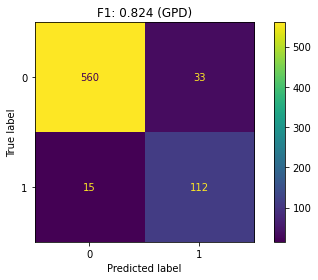

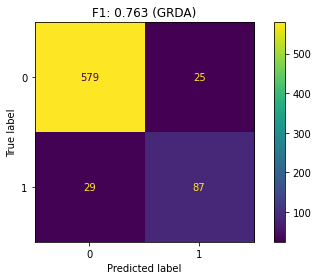

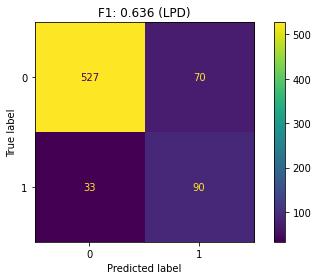

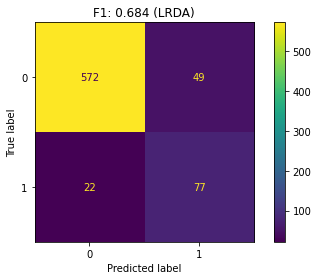

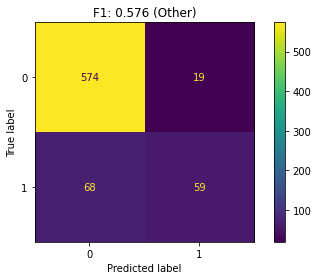

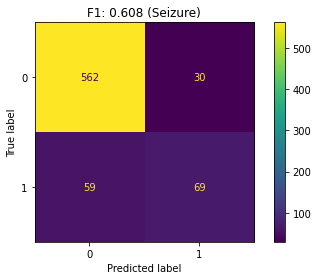

In [75]:
activities = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']
f1_scores = f1_score(y_test, meta_predictions, average = None)
matrices = multilabel_confusion_matrix(y_test, meta_predictions)
for i in range(len(matrices)):
    disp = ConfusionMatrixDisplay(matrices[i])
    disp.plot()
    plt.title('F1: {} ({})'.format(f1_scores[i].round(decimals = 3), activities[i]))
    plt.tight_layout()
    plt.show()

In [80]:
recs = recall_score(y_test, meta_predictions, average = None)
precs = precision_score(y_test, meta_predictions, average = None)

print('Testing Accuracy: {}'.format(accuracy_score(y_test, meta_predictions).round(decimals = 3)))
pd.DataFrame([precs, recs], index = ['Precision', 'Recall'], columns = activities).transpose()

Testing Accuracy: 0.686


,Precision,Recall
GPD,0.772414,0.881890
GRDA,0.776786,0.750000
LPD,0.562500,0.731707
LRDA,0.611111,0.777778
Other,0.756410,0.464567
Seizure,0.696970,0.539062


### RandomForest Meta Model

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42)

xgb = GradientBoostingClassifier(random_state = 42)
svc = LinearSVC(random_state = 42, dual = 'auto')
knn = KNeighborsClassifier(n_neighbors = 3)

In [22]:
xgb.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_val)
svc_predictions = svc.predict(X_val)
knn_predictions = knn.predict(X_val)

X_val_meta = pd.DataFrame([xgb_predictions, svc_predictions, knn_predictions],
                          index = ['xgb', 'svc', 'knn']).transpose()

X_val_meta = pd.get_dummies(X_val_meta, dtype = 'int64')

### Notes on Results Below  
  
This version performs similarly to the version above. Accuracy score basically equivalent on both the training and testing set. I want to try including an RNN and removing the LinearSVC model or the XGBoost model, but beyond that I need to focus on finishing the CNN and getting the presentation done.

In [23]:
X_train_new, X_test, y_train_new, y_test = train_test_split(X_val_meta, y_val, test_size = 0.3, random_state = 42)

forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train_new, y_train_new)
train_predictions = forest.predict(X_train_new)
meta_predictions = forest.predict(X_test)
print('Meta Training')
print(classification_report(y_train_new, train_predictions))
print('Meta Testing')
print(classification_report(y_test, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.87      0.85      0.86       281
        GRDA       0.71      0.83      0.76       256
         LPD       0.76      0.79      0.78       258
        LRDA       0.82      0.85      0.83       312
       Other       0.67      0.53      0.59       275
     Seizure       0.74      0.74      0.74       298

    accuracy                           0.77      1680
   macro avg       0.76      0.77      0.76      1680
weighted avg       0.77      0.77      0.76      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.88      0.83      0.85       127
        GRDA       0.64      0.70      0.67       116
         LPD       0.71      0.78      0.74       123
        LRDA       0.69      0.78      0.73        99
       Other       0.50      0.43      0.46       127
     Seizure       0.63      0.59      0.61       128

    accuracy                           0.68       

In [24]:
metaforest_acc1 = accuracy_score(y_train_new, train_predictions)
metaforest_acc2 = accuracy_score(y_test, meta_predictions)

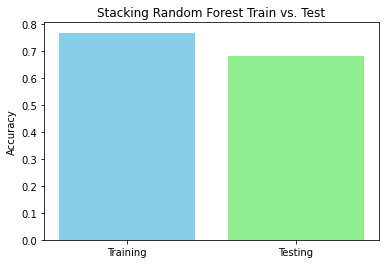

In [27]:
acc_versions = ['Training', 'Testing']
acc_scores = [metaforest_acc1, metaforest_acc2]
plt.bar(acc_versions, acc_scores, color = ['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Stacking Random Forest Train vs. Test')
plt.show()

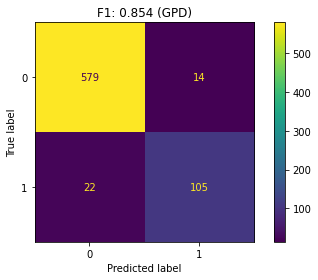

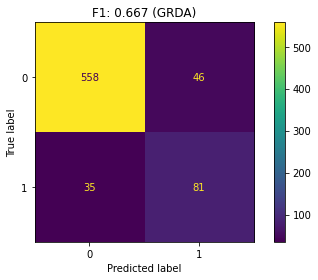

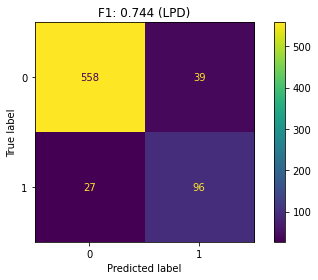

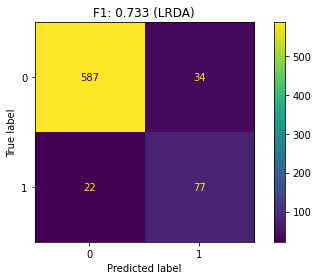

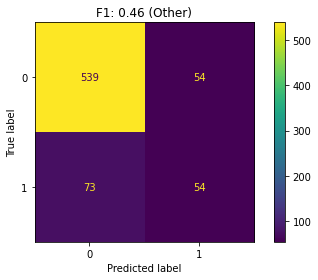

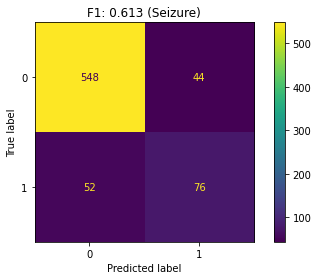

In [28]:
f1_scores = f1_score(y_test, meta_predictions, average = None)
matrices = multilabel_confusion_matrix(y_test, meta_predictions)
for i in range(len(matrices)):
    disp = ConfusionMatrixDisplay(matrices[i])
    disp.plot()
    plt.title('F1: {} ({})'.format(f1_scores[i].round(decimals = 3), activities[i]))
    plt.tight_layout()
    plt.show()

In [33]:
recs = recall_score(y_test, meta_predictions, average = None)
precs = precision_score(y_test, meta_predictions, average = None)

print('Testing Accuracy: {}'.format(accuracy_score(y_test, meta_predictions).round(decimals = 3)))
activity_scores = pd.DataFrame([precs, recs, f1_scores],
                               index = ['Stack_Precision', 'Stack_Recall', 'Stack_F1'],
                               columns = activities).transpose().round(decimals = 3)
activity_scores

Testing Accuracy: 0.679


,Stack_Precision,Stack_Recall,Stack_F1
GPD,0.882,0.827,0.854
GRDA,0.638,0.698,0.667
LPD,0.711,0.780,0.744
LRDA,0.694,0.778,0.733
Other,0.500,0.425,0.460
Seizure,0.633,0.594,0.613


In [35]:
metaforest_acc1.round(decimals = 3), metaforest_acc2.round(decimals = 3)

(0.767, 0.679)

### Cluster Assignments as Feature w/ Stacking Method

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [39]:
k_range = range(4, 13)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 42)
    scores.append(silhouette_score(X_val_meta, kmeans.fit_predict(X_val_meta)))
cluster_scores = pd.DataFrame(scores, index = ['{} Clusters'.format(k) for k in k_range],
                              columns = ['KMeans'])

In [41]:
scores = []
for k in k_range:
    ward = AgglomerativeClustering(n_clusters = k)
    scores.append(silhouette_score(X_val_meta, ward.fit_predict(X_val_meta)))
scores = np.asarray(scores)
cluster_scores['Ward'] = scores

In [42]:
cluster_scores

,KMeans,Ward
4 Clusters,0.287539,0.263815
5 Clusters,0.278539,0.307785
6 Clusters,0.339520,0.334703
7 Clusters,0.396067,0.347371
8 Clusters,0.384833,0.351401
9 Clusters,0.388163,0.357223
10 Clusters,0.393980,0.363481
11 Clusters,0.395472,0.380141
12 Clusters,0.408632,0.387736


In [46]:
kmeans = KMeans(n_clusters = 10, n_init = 'auto', random_state = 42)
kmeans_assignments = kmeans.fit_predict(X_val_meta)

ward = AgglomerativeClustering(n_clusters = 11)
ward_assignments = ward.fit_predict(X_val_meta)

In [52]:
assignments = pd.DataFrame([kmeans_assignments, ward_assignments], index = ['KMeans', 'Ward']).transpose()

cluster_cols = assignments.columns
scaler = MinMaxScaler()
assignments = scaler.fit_transform(assignments)
assignments = pd.DataFrame(assignments, columns = cluster_cols)

In [53]:
X_val_meta_2 = pd.concat([X_val_meta, assignments], axis = 1)

In [65]:
assignments_2 = pd.DataFrame([kmeans_assignments, ward_assignments], index = ['KMeans', 'Ward']).transpose()

assignments_2 = pd.get_dummies(assignments_2)

In [57]:
X_val_meta_3 = pd.concat([X_val_meta, assignments_2], axis = 1)

In [59]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_val_meta_2, y_val, test_size = 0.3, random_state = 42)

In [60]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_val_meta_3, y_val, test_size = 0.3, random_state = 42)

In [61]:
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train2, y_train2)
train_predictions = forest.predict(X_train2)
meta_predictions = forest.predict(X_test2)
print('Meta Training')
print(classification_report(y_train2, train_predictions))
print('Meta Testing')
print(classification_report(y_test2, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.87      0.88      0.87       281
        GRDA       0.69      0.86      0.76       256
         LPD       0.76      0.77      0.76       258
        LRDA       0.82      0.85      0.83       312
       Other       0.71      0.51      0.60       275
     Seizure       0.73      0.73      0.73       298

    accuracy                           0.77      1680
   macro avg       0.76      0.77      0.76      1680
weighted avg       0.77      0.77      0.76      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.88      0.83      0.85       127
        GRDA       0.66      0.74      0.70       116
         LPD       0.73      0.78      0.75       123
        LRDA       0.73      0.81      0.77        99
       Other       0.56      0.46      0.50       127
     Seizure       0.65      0.63      0.64       128

    accuracy                           0.70       

In [62]:
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train3, y_train3)
train_predictions = forest.predict(X_train3)
meta_predictions = forest.predict(X_test3)
print('Meta Training')
print(classification_report(y_train3, train_predictions))
print('Meta Testing')
print(classification_report(y_test3, meta_predictions))

Meta Training
              precision    recall  f1-score   support

         GPD       0.87      0.88      0.87       281
        GRDA       0.69      0.86      0.76       256
         LPD       0.76      0.77      0.76       258
        LRDA       0.82      0.85      0.83       312
       Other       0.71      0.51      0.60       275
     Seizure       0.73      0.73      0.73       298

    accuracy                           0.77      1680
   macro avg       0.76      0.77      0.76      1680
weighted avg       0.77      0.77      0.76      1680

Meta Testing
              precision    recall  f1-score   support

         GPD       0.88      0.83      0.85       127
        GRDA       0.66      0.74      0.70       116
         LPD       0.73      0.78      0.75       123
        LRDA       0.73      0.81      0.77        99
       Other       0.56      0.46      0.50       127
     Seizure       0.65      0.63      0.64       128

    accuracy                           0.70       

In [63]:
X_val_meta_3

,xgb_GPD,xgb_GRDA,xgb_LPD,xgb_LRDA,xgb_Other,xgb_Seizure,svc_GPD,svc_GRDA,svc_LPD,svc_LRDA,svc_Other,svc_Seizure,knn_GPD,knn_GRDA,knn_LPD,knn_LRDA,knn_Other,knn_Seizure,KMeans,Ward
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,8
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,5
3,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,7
4,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,5,2
2396,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,1
2397,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,10
2398,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,5,2


### KernelPCA Attempt

In [51]:
from sklearn.decomposition import KernelPCA

In [54]:
kpca = KernelPCA(n_components = 40)
X_kpca = kpca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, test_size = 0.1, random_state = 42)

### Notes on Results Below  
  
The results for KernelPCA are equivalent to the results with PCA.

In [56]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('KPCA Training')
print(classification_report(y_train, training_yhat))
print('KPCA Testing')
print(classification_report(y_test, testing_yhat))

KPCA Training
              precision    recall  f1-score   support

         GPD       0.86      0.97      0.91      1794
        GRDA       0.85      0.92      0.89      1819
         LPD       0.84      0.93      0.88      1800
        LRDA       0.91      0.94      0.93      1795
       Other       0.91      0.71      0.80      1808
     Seizure       0.93      0.81      0.86      1784

    accuracy                           0.88     10800
   macro avg       0.88      0.88      0.88     10800
weighted avg       0.88      0.88      0.88     10800

KPCA Testing
              precision    recall  f1-score   support

         GPD       0.80      0.92      0.85       206
        GRDA       0.68      0.84      0.75       181
         LPD       0.73      0.82      0.77       200
        LRDA       0.81      0.82      0.82       205
       Other       0.67      0.45      0.54       192
     Seizure       0.81      0.66      0.73       216

    accuracy                           0.75      1

In [60]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [61]:
help(multilabel_confusion_matrix)

Help on function multilabel_confusion_matrix in module sklearn.metrics._classification:

multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
    Compute a confusion matrix for each class or sample.
    
    .. versionadded:: 0.21
    
    Compute class-wise (default) or sample-wise (samplewise=True) multilabel
    confusion matrix to evaluate the accuracy of a classification, and output
    confusion matrices for each class or sample.
    
    In multilabel confusion matrix :math:`MCM`, the count of true negatives
    is :math:`MCM_{:,0,0}`, false negatives is :math:`MCM_{:,1,0}`,
    true positives is :math:`MCM_{:,1,1}` and false positives is
    :math:`MCM_{:,0,1}`.
    
    Multiclass data will be treated as if binarized under a one-vs-rest
    transformation. Returned confusion matrices will be in the order of
    sorted unique labels in the union of (y_true, y_pred).
    
    Read more in the :ref:`User Guide <multilabel_confusion_mat

In [62]:
matrices = multilabel_confusion_matrix(y_test, testing_yhat)

In [63]:
disp = ConfusionMatrixDisplay(matrices[0])

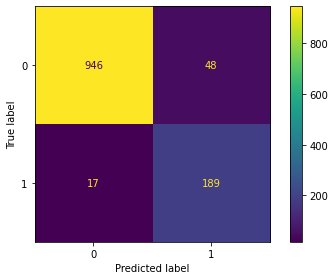

In [65]:
disp.plot()
plt.tight_layout()
plt.show()

### Stacking w/ RNN  
  
I think I'm going to talk about this as an idea for future work building off of the initial results shown above rather than actually trying to build an RNN due to time constraints. I'm not experienced enough with building neural networks and I still need to get the CNN model working, but I do find the resolution of the overfitting problem I've had via stacking significant, so I want to discuss it during my presentation and then talk about what I could do to improve these results in the future work section.